### Pytorch Neural Network Classification

In [7]:
%pip install scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
import sklearn
from sklearn.datasets import make_circles

In [9]:
n_samples = 1000
X,y = make_circles(n_samples,noise=0.05,random_state=42)

In [10]:
len(X),len(y)

(1000, 1000)

In [11]:
print(f"First Five Samples Of X {X[:5]}")
print(f"First Five Samples Of y {y[:5]}")

First Five Samples Of X [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
First Five Samples Of y [1 1 1 1 0]


In [12]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


### Visualize

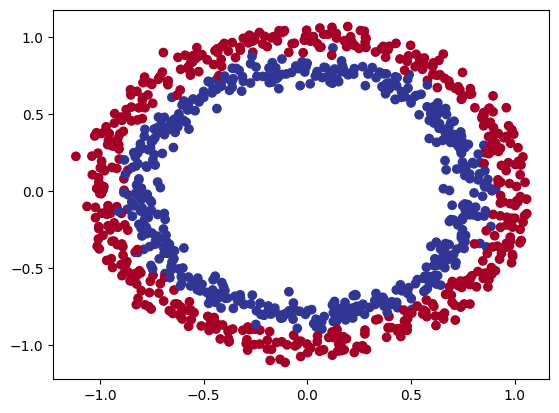

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=circles['X1'],
            y=circles['X2'],
            c=circles['label'],
            cmap='RdYlBu')

### Check Input And Output Shapes

In [14]:
X.shape,y.shape

((1000, 2), (1000,))

In [15]:
X_sample = X[0]
y_sample = y[0]
print(f"Values of X sample {X_sample} and y sample {y_sample}")
print(f"Shape of X sample {X_sample.shape} and y sample {y.shape}")

Values of X sample [0.74220688 0.24668576] and y sample 1
Shape of X sample (2,) and y sample (1000,)


In [16]:
import torch

In [17]:
# Turn Data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [18]:
# Create Train Test Split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [19]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### Building The Model

In [20]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [21]:
X_train

tensor([[ 0.6772, -0.4456],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        ...,
        [ 0.0011, -1.0504],
        [ 1.0259,  0.1799],
        [ 0.5597, -0.5673]])

In [22]:
from sklearn import datasets
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)
    def forward(self,x):
        return self.layer_2(self.layer_1(x))

In [23]:
linear = CircleModelV0().to(device)
linear

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
linear.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.3836, -0.0736],
                      [ 0.0116, -0.5256],
                      [-0.2566,  0.1522],
                      [-0.1353, -0.4521],
                      [ 0.5752,  0.4010]])),
             ('layer_1.bias',
              tensor([ 0.0349,  0.7033, -0.0444, -0.0640, -0.2072])),
             ('layer_2.weight',
              tensor([[-0.1773,  0.0369, -0.0267, -0.1816, -0.1730]])),
             ('layer_2.bias', tensor([-0.3893]))])

In [25]:
#Make Predictions
with torch.inference_mode():
    untrained_preds = linear(X_test.to(device))
print(f"Length Of Predictions Samples {len(untrained_preds)},Shape {untrained_preds.shape}")
print(f"Length Of Test Samples {len(X_test)} Shape {X_test.shape}")
print(f"\nFirst 10 Predictions:\n {(untrained_preds[30:70])}")
print(f"\nFirst 10 Labels:\n {y_test[:10]}")

Length Of Predictions Samples 200,Shape torch.Size([200, 1])
Length Of Test Samples 200 Shape torch.Size([200, 2])

First 10 Predictions:
 tensor([[-0.4020],
        [-0.3956],
        [-0.2630],
        [-0.3337],
        [-0.2534],
        [-0.3359],
        [-0.2827],
        [-0.2328],
        [-0.3134],
        [-0.2523],
        [-0.2223],
        [-0.2120],
        [-0.3705],
        [-0.3758],
        [-0.2601],
        [-0.3423],
        [-0.3944],
        [-0.3180],
        [-0.3211],
        [-0.3986],
        [-0.2746],
        [-0.2643],
        [-0.4427],
        [-0.3606],
        [-0.4193],
        [-0.2840],
        [-0.4294],
        [-0.2290],
        [-0.2082],
        [-0.1861],
        [-0.3880],
        [-0.4433],
        [-0.1959],
        [-0.2524],
        [-0.2773],
        [-0.3114],
        [-0.4276],
        [-0.4536],
        [-0.3444],
        [-0.4427]])

First 10 Labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [26]:
#Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
linear_optimizer = torch.optim.SGD(params=linear.parameters(),
                                   lr=0.001)

In [27]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Training The Model

In [28]:
linear.eval()
with torch.inference_mode():
    y_logits = linear(X_test.to(device))[:5]
y_logits

tensor([[-0.2702],
        [-0.3268],
        [-0.2285],
        [-0.2842],
        [-0.3749]])

In [29]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4329],
        [0.4190],
        [0.4431],
        [0.4294],
        [0.4074]])

In [30]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(linear(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [31]:
if(device == 'cuda'):
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)
###Training Loop
epochs = 100

y_test, y_train = y_test.to(device), y_train.to(device)
X_train, X_test = X_train.to(device), X_test.to(device)

###Tracking Info

epochs_count = []
loss_count = []
test_loss_count = []

for epoch in range(epochs):
    #Sets the model to training mode 
    linear.train() #-> train mode in pytorch sets required gradients to require gradients

    # 1.Forward pass
    y_logits = linear(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #turns logits -> pred probs -> pred labels
    
    # 2.Calculate The Loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    # 3.Optimizer Zero Grad
    linear_optimizer.zero_grad()

    # 4. Perform Backpropagation on the loss with respect to the model parameters
    loss.backward()

    # 5.Step the optimizer
    linear_optimizer.step()

    # Testing
    linear.eval() # -> turns off gradient tracking
    with torch.inference_mode():
        test_logits = linear(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_accuracy = accuracy_fn(y_true=y_test,y_pred=test_pred)
    
    if epoch % 10 == 0:
        epochs_count.append(epoch)
        loss_count.append(loss)
        test_loss_count.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.70714, Accuracy: 50.00% | Test loss: 0.70553, Test acc: 50.00%
Epoch: 10 | Loss: 0.70704, Accuracy: 50.00% | Test loss: 0.70543, Test acc: 50.00%
Epoch: 20 | Loss: 0.70694, Accuracy: 50.00% | Test loss: 0.70532, Test acc: 50.00%
Epoch: 30 | Loss: 0.70684, Accuracy: 50.00% | Test loss: 0.70522, Test acc: 50.00%
Epoch: 40 | Loss: 0.70674, Accuracy: 50.00% | Test loss: 0.70512, Test acc: 50.00%
Epoch: 50 | Loss: 0.70664, Accuracy: 50.00% | Test loss: 0.70501, Test acc: 50.00%
Epoch: 60 | Loss: 0.70654, Accuracy: 50.00% | Test loss: 0.70491, Test acc: 50.00%
Epoch: 70 | Loss: 0.70645, Accuracy: 50.00% | Test loss: 0.70481, Test acc: 50.00%
Epoch: 80 | Loss: 0.70635, Accuracy: 50.00% | Test loss: 0.70471, Test acc: 50.00%
Epoch: 90 | Loss: 0.70626, Accuracy: 50.00% | Test loss: 0.70461, Test acc: 50.00%


### To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

In [32]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [33]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [34]:
import matplotlib.pyplot as plt

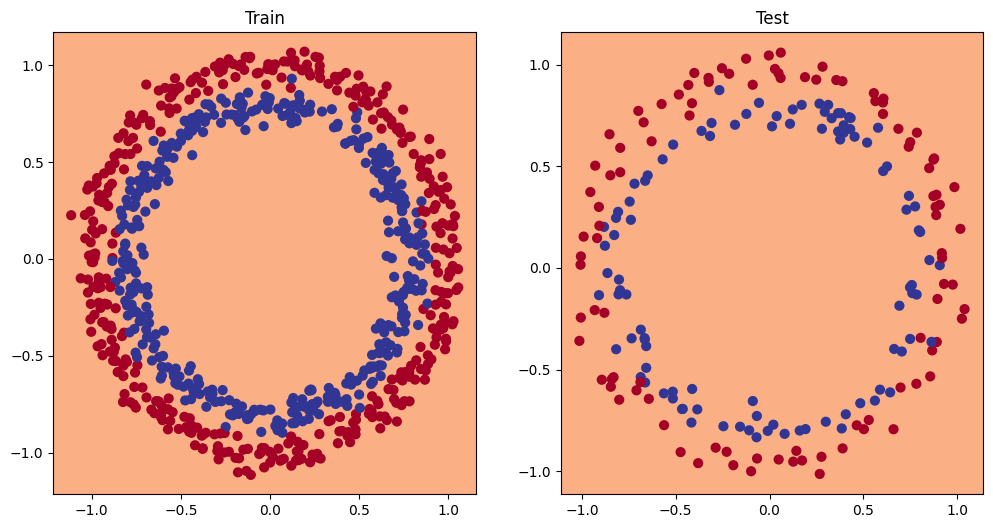

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(linear, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(linear, X_test, y_test)

### Improving The Model

In [36]:
#Make the Model with the activation functions and more hidden states
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [37]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [39]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69393, Accuracy: 51.00% | Test loss: 0.69264, Test acc: 50.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69436, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69456, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69463, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69465, Test acc: 45.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%


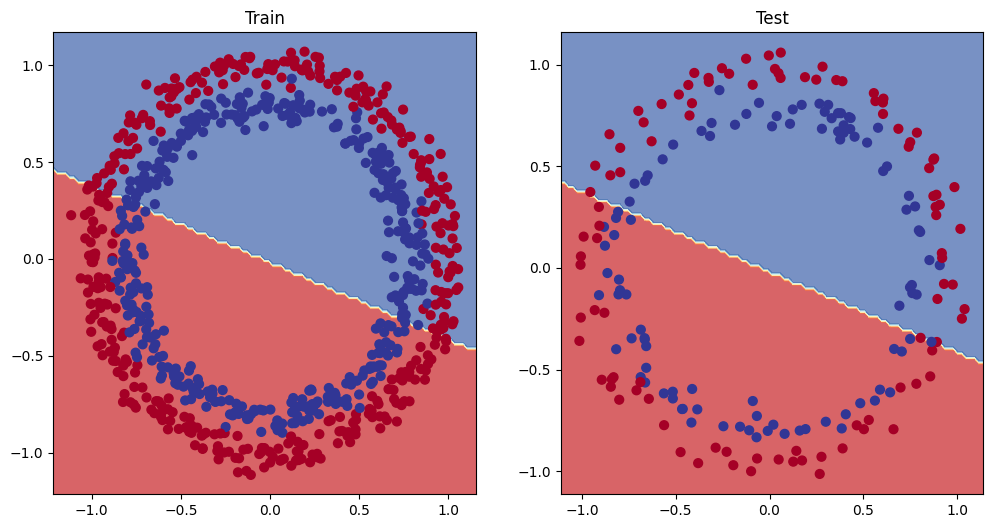

In [40]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### The missing piece: non-linearity

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

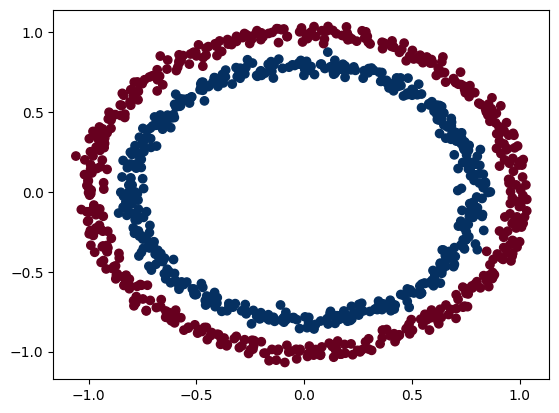

In [41]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [42]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building The Model With Non-linearity

In [43]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [44]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [45]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

In [46]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
y_test[:10],y_preds[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

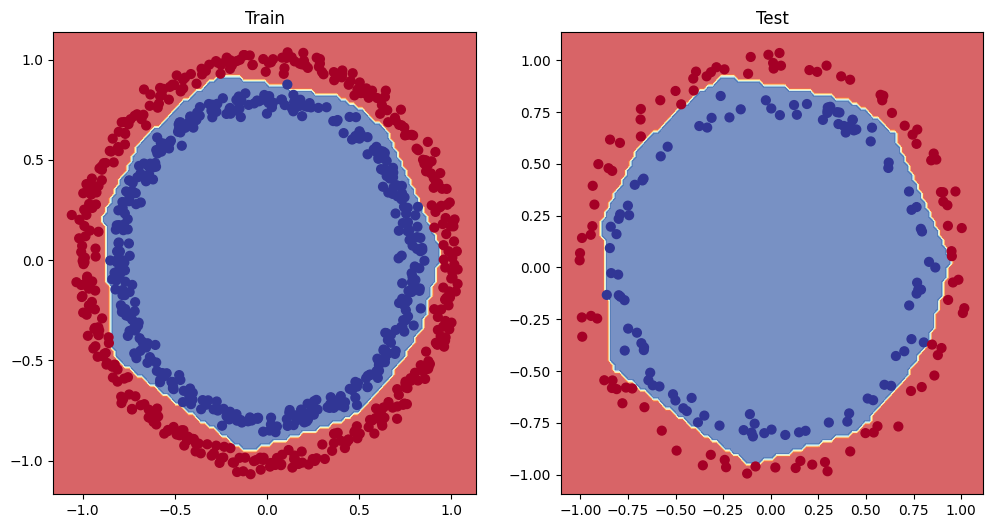

In [47]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### Saving Model

In [77]:
from pathlib import Path
Model_Path = Path("models")
Model_Path.mkdir(parents=True,exist_ok=True)

Model_Name = "Binary_classClassification.pth"
Model_Save_Path = Model_Path / Model_Name

print(f"Saving Model To {Model_Save_Path}")
torch.save(obj=model_3.state_dict(),f=Model_Save_Path)

Saving Model To models/Binary_classClassification.pth


In [78]:
loaded_model = CircleModelV2()

In [79]:
loaded_model.load_state_dict(torch.load(Model_Save_Path))

<All keys matched successfully>

In [80]:
loaded_model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.9300,  1.5243],
                      [-0.5232,  1.9216],
                      [-0.1549,  0.1427],
                      [-2.3392, -0.1767],
                      [ 0.6889, -2.3658],
                      [ 1.2308, -0.0741],
                      [ 1.6332,  0.1051],
                      [ 0.3410, -0.0998],
                      [ 0.8671,  0.7070],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.2412, -0.9001, -0.2872, -0.4221, -0.5646, -0.5747, -0.7351, -0.4252,
                      -0.2219, -0.6984])),
             ('layer_2.weight',
              tensor([[-0.0311, -0.7215,  0.2441, -0.3385, -0.4142, -0.0497, -0.2312,  0.2555,
                       -0.1172, -0.0997],
                      [ 1.5930,  1.8717,  0.1331,  2.1387,  2.0953,  1.0247,  1.5361,  0.0566,
                        0.9802, -0.1927],
                      [-0.3130, -0.1244, -0.2426,  0.1733,  0.0911,  0.1

In [48]:
# Replicating Non-linear Function
A = torch.arange(-10,10,step=1,dtype=torch.float)
A.dtype

torch.float32

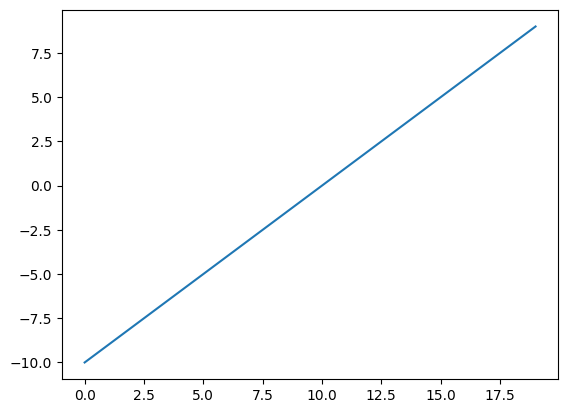

In [49]:
#Visualize
plt.plot(A)

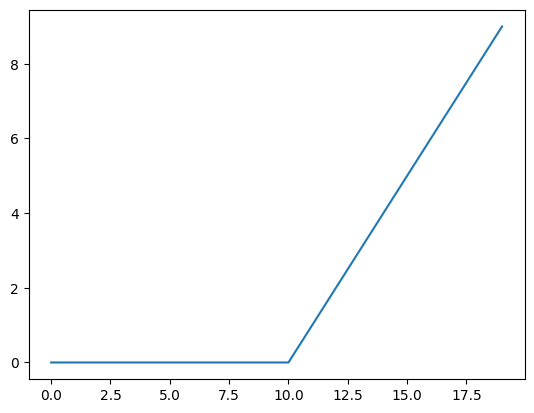

In [50]:
plt.plot(torch.relu(A))

In [51]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [52]:
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

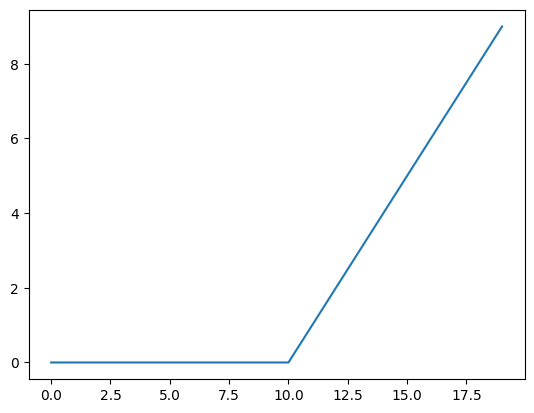

In [53]:
plt.plot(relu(A))

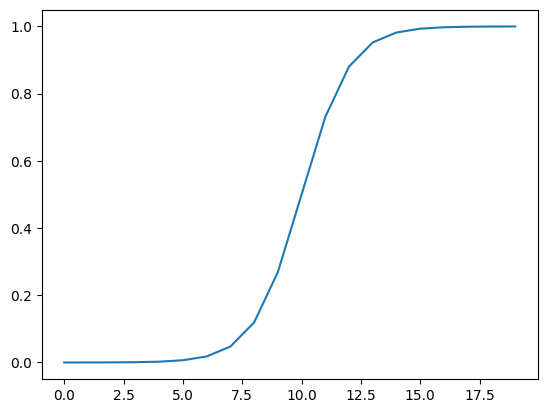

In [54]:
plt.plot(torch.sigmoid(A))

In [55]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

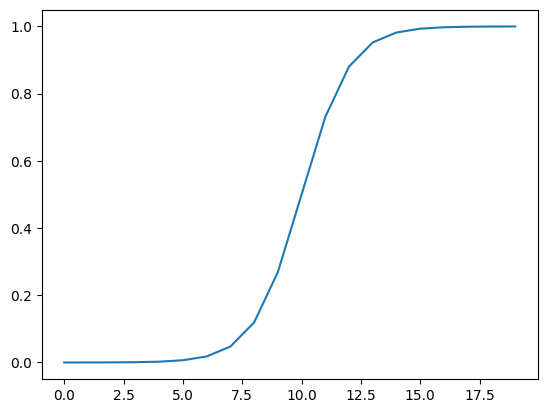

In [56]:
plt.plot(sigmoid(A))

### Multi-Class Classification

In [57]:
#Making Datasets
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

In [58]:
NUM_CLASSES = 4
NUM_FEATURES = 2
# Generate synthetic classification data
X, y = make_blobs(n_samples=1000, 
                  centers=NUM_CLASSES, 
                  n_features=NUM_FEATURES, 
                  cluster_std=1.5, 
                  random_state=42)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

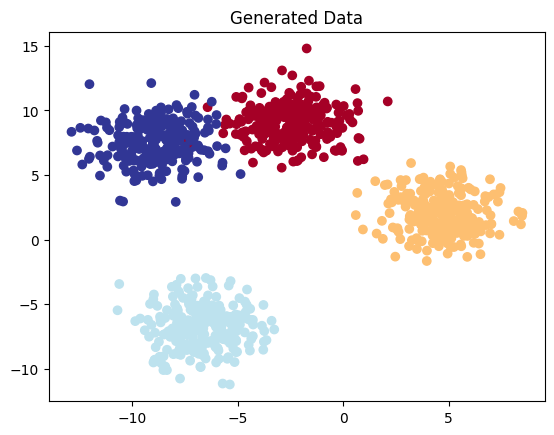

In [59]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Generated Data")
plt.show()

In [60]:
import torch.nn as nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_states=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, hidden_states),
            nn.ReLU(),
            nn.Linear(hidden_states, hidden_states),
            nn.ReLU(),
            nn.Linear(hidden_states, output_features)
        )

    def forward(self, x):
        return self.model(x)


In [61]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS=1000
# Training loop
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in train_loader:
        model.train()
        xb,yb = xb.to(device), yb.to(device)
        blob_preds = model(xb)
        loss = criterion(blob_preds, yb)
        acc = accuracy_fn(yb, torch.argmax(torch.softmax(blob_preds, dim=1), dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_preds = model(X_test.to(device))
        test_loss = criterion(test_preds, y_test.to(device))
        test_acc = accuracy_fn(y_test.to(device), torch.argmax(torch.softmax(test_preds, dim=1), dim=1))


    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f} Accuracy: {acc:.2f} ,TestLoss:{test_loss:.4f} TestAccuracy:{test_acc:.2f}")

Epoch 0, Loss: 16.3462 Accuracy: 96.88 ,TestLoss:0.2921 TestAccuracy:99.50
Epoch 100, Loss: 0.4151 Accuracy: 100.00 ,TestLoss:0.0037 TestAccuracy:100.00
Epoch 200, Loss: 0.5381 Accuracy: 100.00 ,TestLoss:0.0024 TestAccuracy:100.00
Epoch 300, Loss: 0.3637 Accuracy: 100.00 ,TestLoss:0.0043 TestAccuracy:100.00
Epoch 400, Loss: 0.3637 Accuracy: 100.00 ,TestLoss:0.0057 TestAccuracy:100.00
Epoch 500, Loss: 0.3971 Accuracy: 100.00 ,TestLoss:0.0031 TestAccuracy:100.00
Epoch 600, Loss: 0.3747 Accuracy: 100.00 ,TestLoss:0.0062 TestAccuracy:100.00
Epoch 700, Loss: 0.3542 Accuracy: 100.00 ,TestLoss:0.0052 TestAccuracy:100.00
Epoch 800, Loss: 0.3201 Accuracy: 100.00 ,TestLoss:0.0054 TestAccuracy:100.00
Epoch 900, Loss: 0.3536 Accuracy: 100.00 ,TestLoss:0.0041 TestAccuracy:100.00


In [62]:
model.eval()
with torch.inference_mode():
    # Get predictions for test data only
    test_logits = model(X_test.to(device))
    # Turn predicted logits into prediction probabilities
    y_pred_probs = torch.softmax(test_logits, dim=1)
    # Turn prediction probabilities into prediction labels
    y_preds = y_pred_probs.argmax(dim=1)
    # Compare first 10 model preds and test labels
    print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
    print(f"Test accuracy: {accuracy_fn(y_true=y_test.to(device), y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 100.0%


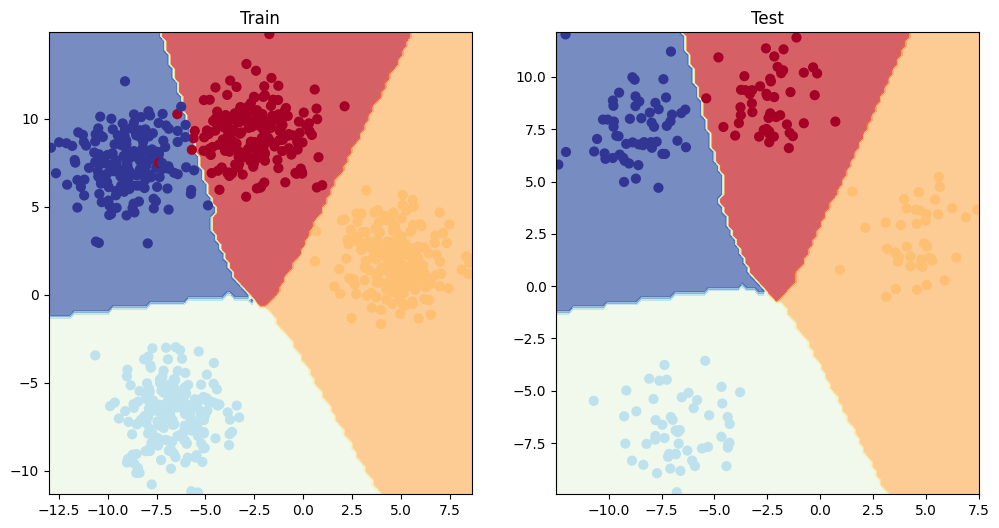

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train.to(device), y_train.to(device))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test.to(device), y_test.to(device))

In [64]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [65]:
from torchmetrics.classification import Accuracy,Precision,Recall


In [66]:
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

In [67]:
torchmetrics_accuracy(y_preds,y_test)

tensor(1.)

In [68]:
torchmetrics_precision = Precision(task='multiclass',num_classes=NUM_CLASSES)

In [69]:
torchmetrics_precision(y_preds,y_test)

tensor(1.)

In [70]:
torchmetrics_recall = Recall(task="multiclass",num_classes=NUM_CLASSES)

In [71]:
torchmetrics_recall(y_preds,y_test)

tensor(1.)

### Saving The Model

In [72]:
from pathlib import Path
Model_Path = Path("models")
Model_Path.mkdir(parents=True,exist_ok=True)

Model_Name = "Multi_classClassification.pth"
Model_Save_Path = Model_Path / Model_Name

print(f"Saving Model To {Model_Save_Path}")
torch.save(obj=model.state_dict(),f=Model_Save_Path)

Saving Model To models/Multi_classClassification.pth


In [74]:
loading_model = BlobModel(input_features=NUM_FEATURES,output_features=NUM_CLASSES)

In [75]:
loading_model.load_state_dict(torch.load(Model_Save_Path))

<All keys matched successfully>

In [76]:
loading_model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ 1.2330,  0.2687],
                      [ 0.1021,  0.0415],
                      [-1.3738, -1.1187],
                      [-1.0143,  0.4520],
                      [-0.3297, -2.0598],
                      [ 1.8569,  0.8592],
                      [ 1.5474, -0.5362],
                      [ 1.2193, -0.5910]])),
             ('model.0.bias',
              tensor([ 3.3842, -3.2094, -2.0336, -3.7304, -0.0263,  4.2559,  1.7684,  2.4851])),
             ('model.2.weight',
              tensor([[-2.7908e-01, -1.6299e-01, -9.9835e-02, -2.1258e-01,  3.3369e-02,
                       -3.4920e-01,  3.1930e-01, -3.0033e-01],
                      [ 8.6706e-02, -1.4504e-01, -5.6199e-01, -4.5315e-01, -1.2460e-01,
                        8.5034e-01, -2.0846e+00, -3.3030e+00],
                      [-4.3048e-01, -1.5240e-01,  7.0666e-01,  3.2805e-01, -2.4893e-01,
                       -4.6814e+00,  6.5569e-02, -8.3771e-02],
                 